In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

%matplotlib inline

In [2]:
folder = input("What folder is your data located in?\n")

What folder is your data located in?
/Volumes/icm_102/BigData/results


In [41]:
os.listdir(folder)

['.DS_Store',
 'bridges-tunnels-daily-sumtraffic.csv',
 'bridges-tunnels-monthly-sumtraffic.csv',
 'citibike-daily-counttrips.csv',
 'citibike-daily-sumtriphours.csv',
 'citibike-monthly-counttrips.csv',
 'citibike-monthly-sumtriphours.csv',
 'COVID_cases_daily.csv',
 'pedestrianCountGroupByDate.out',
 'taxi_trips_per_day.csv',
 'tsa-daily-travelers.csv',
 'Turnstile_Usage_Data__2020_trips_per_day.csv']

In [93]:
df_citibike_count = pd.read_csv(folder + '/' + 'citibike-daily-counttrips.csv', names = ["date", "citibike_count"])
df_citibike_count["date"] = pd.to_datetime(df_citibike_count["date"])

df_citibike_sum = pd.read_csv(folder + '/' + 'citibike-daily-sumtriphours.csv', names = ["date", "citibike_sum"])
df_citibike_sum["date"] = pd.to_datetime(df_citibike_sum["date"])

df_bridges = pd.read_csv(folder + '/' + 'bridges-tunnels-daily-sumtraffic.csv', names = ["date", "bridges"])
df_bridges["date"] = pd.to_datetime(df_bridges["date"])

df_tsa = pd.read_csv(folder + '/' + 'tsa-daily-travelers.csv', names = ["date", "tsa"])
df_tsa["date"] = pd.to_datetime(df_tsa["date"])

df_turnstile = pd.read_csv(folder + '/' + 'Turnstile_Usage_Data__2020_trips_per_day.csv', names = ["date", "turnstile"])
df_turnstile["date"] = pd.to_datetime(df_turnstile["date"])

df_taxi = pd.read_csv(folder + '/' + 'taxi_trips_per_day.csv', names = ["date", "taxi"])
df_taxi["date"] = pd.to_datetime(df_taxi["date"])

df_pedestrians = pd.read_csv(folder + '/' + 'pedestrianCountGroupByDate.out', sep = ", ", names = ["date", "pedestrians"])
df_pedestrians["date"] = pd.to_datetime(df_pedestrians["date"])

df_covid19 = pd.read_csv(folder + '/' + 'COVID_cases_daily.csv')
df_covid19["DATE_OF_INTEREST"] = pd.to_datetime(df_covid19["DATE_OF_INTEREST"])


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:19: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [94]:
df_covid19

,DATE_OF_INTEREST,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT
0,2020-02-29,1,0,0
1,2020-03-01,0,0,0
2,2020-03-02,0,0,0
3,2020-03-03,1,1,0
4,2020-03-04,5,2,0
...,...,...,...,...
274,2020-11-29,1622,133,11
275,2020-11-30,2580,152,17
276,2020-12-01,2665,157,17
277,2020-12-02,2087,125,22


In [95]:
#df_taxi.join(df_bridges, on="date", how="outer")
total = df_taxi.set_index('date').join(df_pedestrians.set_index('date'), how="outer")
total = total.join(df_turnstile.set_index("date"), how="outer")
total = total.join(df_tsa.set_index("date"), how="outer")
total = total.join(df_bridges.set_index("date"), how="outer")
total = total.join(df_citibike_sum.set_index("date"), how="outer")
total = total.join(df_citibike_count.set_index("date"), how="outer")
total = total.join(df_covid19.set_index("DATE_OF_INTEREST"), how= "outer")

In [96]:
total = total.sort_index()

In [97]:
total

,taxi,pedestrians,turnstile,tsa,bridges,citibike_sum,citibike_count,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT
2017-10-01,NaN,22525.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-02,NaN,12597.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-03,NaN,9815.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-04,NaN,15622.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-10-05,NaN,17994.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-11-30,NaN,NaN,1866300.0,981912.0,NaN,5184.708333,23257.0,2580.0,152.0,17.0
2020-12-01,NaN,NaN,1708942.0,780283.0,NaN,NaN,NaN,2665.0,157.0,17.0
2020-12-02,NaN,NaN,1694053.0,632356.0,NaN,NaN,NaN,2087.0,125.0,22.0
2020-12-03,NaN,NaN,2045713.0,738050.0,NaN,NaN,NaN,1126.0,77.0,9.0


In [107]:
valid = total.loc["2020-03-01" : "2020-06-30"]

In [115]:
valid

,taxi,pedestrians,turnstile,tsa,bridges,citibike_sum,citibike_count,CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT
2020-03-01,44800.0,6051.0,2183588.0,2280522.0,688870.0,7651.791944,31878.0,0.0,0.0,0.0
2020-03-02,65168.0,8485.0,7378650.0,2089641.0,764768.0,15542.090556,56946.0,0.0,0.0,0.0
2020-03-03,68632.0,5721.0,5457693.0,1736393.0,771447.0,11761.236389,49723.0,1.0,1.0,0.0
2020-03-04,69476.0,8110.0,8085743.0,1877401.0,792404.0,13877.790278,58670.0,5.0,2.0,0.0
2020-03-05,69880.0,6074.0,5480697.0,2130015.0,814060.0,13756.960000,58686.0,3.0,8.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2020-06-26,37655.0,8079.0,1539658.0,632984.0,721792.0,31528.894444,73638.0,314.0,41.0,20.0
2020-06-27,29040.0,5531.0,556987.0,546310.0,540388.0,25974.426389,59221.0,207.0,40.0,19.0
2020-06-28,23562.0,7585.0,483559.0,633810.0,539500.0,29962.134167,69104.0,203.0,35.0,19.0
2020-06-29,37264.0,2615.0,1721872.0,625235.0,667153.0,23194.826389,61574.0,438.0,50.0,22.0


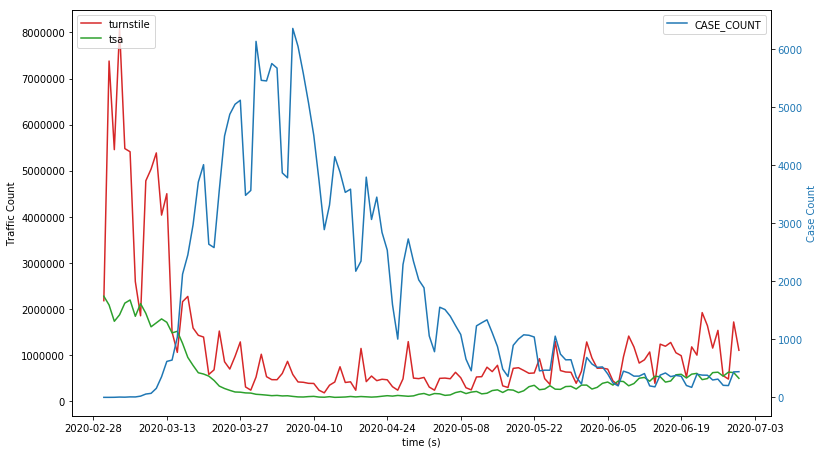

In [136]:
fig, ax1 = plt.subplots()

color1 = 'tab:red'
color2 = 'tab:green'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Traffic Count')
ax1.plot(valid.index, valid["turnstile"], color=color1)
ax1.plot(valid.index, valid["tsa"], color=color2)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Case Count', color=color)  # we already handled the x-label with ax1
ax2.plot(valid.index, valid["CASE_COUNT"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.set_figheight(7)
fig.set_figwidth(14)
ax1.legend(loc="upper left", bbox_to_anchor=(0,1))
ax2.legend(loc="upper right", bbox_to_anchor=(1,1))

plt.show()

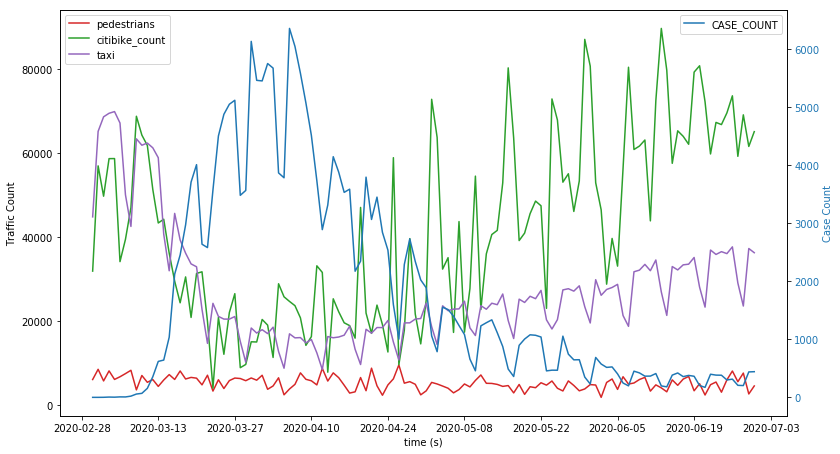

In [138]:
fig, ax1 = plt.subplots()

color1 = 'tab:red'
color2 = 'tab:green'
color3 = 'tab:purple'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Traffic Count')
ax1.plot(valid.index, valid["pedestrians"], color=color1)
ax1.plot(valid.index, valid["citibike_count"], color=color2)
ax1.plot(valid.index, valid["taxi"], color=color3)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Case Count', color=color)  # we already handled the x-label with ax1
ax2.plot(valid.index, valid["CASE_COUNT"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.set_figheight(7)
fig.set_figwidth(14)
ax1.legend(loc="upper left", bbox_to_anchor=(0,1))
ax2.legend(loc="upper right", bbox_to_anchor=(1,1))

plt.show()

In [143]:
valid_weekavg = total.loc["2020-02-22" : "2020-06-30"].rolling(window=7).mean()
valid_weekavg = valid_weekavg["2020-03-01":]

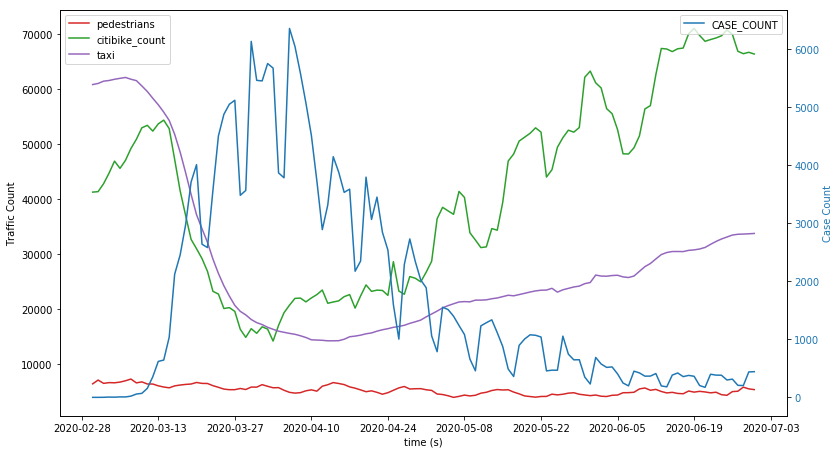

In [144]:
fig, ax1 = plt.subplots()

color1 = 'tab:red'
color2 = 'tab:green'
color3 = 'tab:purple'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Traffic Count')
ax1.plot(valid.index, valid_weekavg["pedestrians"], color=color1)
ax1.plot(valid.index, valid_weekavg["citibike_count"], color=color2)
ax1.plot(valid.index, valid_weekavg["taxi"], color=color3)
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Case Count', color=color)  # we already handled the x-label with ax1
ax2.plot(valid.index, valid["CASE_COUNT"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.set_figheight(7)
fig.set_figwidth(14)
ax1.legend(loc="upper left", bbox_to_anchor=(0,1))
ax2.legend(loc="upper right", bbox_to_anchor=(1,1))

plt.show()

In [152]:
model = LinearRegression()

x = valid[["taxi", "pedestrians", "turnstile", "tsa", "bridges", "citibike_sum", "citibike_count"]]
y = valid[["CASE_COUNT"]]
model.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [153]:
r_sq = model.score(x, y)
r_sq

0.6519610567537406

In [154]:
model.intercept_[0]

4844.808291036315

In [155]:
model.coef_

array([[ 0.02431226,  0.07066174,  0.00025449, -0.00081032, -0.00519282,
         0.03404572, -0.05426571]])

In [156]:
#Polynomial Regression

In [164]:
degree=2
p_features = PolynomialFeatures(degree=degree)
plRegressor = LinearRegression()
model = Pipeline(steps=[("polyFeature", p_features), ("regression", plRegressor)])
model.fit(x, y)

Pipeline(memory=None,
         steps=[('polyFeature',
                 PolynomialFeatures(degree=2, include_bias=True,
                                    interaction_only=False, order='C')),
                ('regression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [165]:
r_sq = model.score(x, y)
r_sq

0.7717098179345767